In [1]:
import numpy as np
import numpy.ma as ma
import xarray as xr
import pandas as pd
from scipy import stats
import scipy
from scipy.interpolate import make_interp_spline, BSpline
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter
import matplotlib.path as mpath
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.image as mpimg
from matplotlib.offsetbox import TextArea, VPacker, AnnotationBbox

%matplotlib inline
from IPython.display import Image, display

In [2]:
## import subset SB AR MERRA2 file
# SBfilename = '/home/sbarc/students/nash/data/MERRA-2/SB_AR_vertical_vapor_flux.nc'
SBfilename = '/home/sbarc/students/nash/data/MERRA-2/SB_march_AR_vertical_vapor_flux.nc'
ds_merra = xr.open_dataset(SBfilename)
MERRA_flux = np.sqrt((ds_merra.U*ds_merra.QV)**2 + (ds_merra.V*ds_merra.QV)**2)

data_plot = []
for i in MERRA_flux.lev.values:
    data_plot.append(MERRA_flux.sel(lev=i).values)
    
merra_mean = MERRA_flux.mean('time')

/home/sbarc/students/nash/anaconda3/envs/pyclivac/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [3]:
g = -9.81 # gravity constant
u = ds_merra.U[:,3:].squeeze()
v = ds_merra.V[:,3:].squeeze()
q = ds_merra.QV[:,3:].squeeze()
p = ds_merra.lev.values[3:].squeeze()
ivt_u = scipy.integrate.trapz(u*q, p, axis=1)*g
print(ivt_u.shape)
ivt_v = scipy.integrate.trapz(v*q, p, axis=1)*g
print(ivt_v.shape)
ivt_total = np.sqrt(ivt_u**2 + ivt_v**2)
# ivt_total = ivt_total.squeeze()
print(ivt_total.shape)

(170,)
(170,)
(170,)


In [4]:
ivt_avg = np.nanmean(ivt_total)
ivt_avg

158.55202411278432

In [5]:
## Latitude and longitude of Santa Barbara
SB_lat = 34.5
SB_lon = -119.5+360

# ## location of maxiumum lightning strikes between 4 and 5 UTC 6 March 2019
# SB_lat = 34.0
# SB_lon = -120.0+360.0

def preprocess(ds):
    '''keep only the selected lats and lons'''
    return ds.sel(latitude=SB_lat, longitude=SB_lon)

filename_pattern =  '/home/sbarc/students/nash/data/CFSv2/netcdf_CFSv2_vertical_levels/201*'
ds = xr.open_mfdataset(filename_pattern, engine='netcdf4', preprocess=preprocess, combine='by_coords')
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds = ds.sel(time=slice('2019-03-04-18', '2019-03-06-18'))
ds.p.attrs['units'] = 'mbar'
# ds

da_MSL = ds.PRMSL_meansealevel
da_MSL = da_MSL/100 # convert to hPa

da_CAPE = ds.capesfc
da_CIN = ds.cinsfc

pressure = ds.p
da_SPFH = ds.spfh
da_V = ds.v
da_V_knots = da_V * 1.94384 ## convert to knots
da_U = ds.u
da_U_knots = da_U * 1.94384 ## convert to knots
T_kel = ds.temp.values * units.kelvin
T_cel = T_kel.to(units.degC)
da_RH = ds.rh
da_GPH = ds.hgtprs
zero_isotherm = ds.hgt_0Cisotherm

ds size in GB 0.00



In [6]:
filename = '/home/sbarc/students/nash/data/M2I6NPANA.5.12.4/thunderstorm_march2019/MERRA2_400.inst6_3d_ana_Np.20190306.nc4'
ds_MERRA = xr.open_dataset(filename)
ds_MERRA = ds_MERRA.sel(time='2019-03-06-06', lon=-119.375, lat=34.5, lev=slice(1000.0, 300.0))
ds_MERRA

## Calculate water vapor flux at each level (m/s)
wvf_merraU = ds_MERRA.U*ds_MERRA.QV
wvf_merraV = ds_MERRA.V*ds_MERRA.QV

wvf_merra = np.sqrt(wvf_merraU**2 + wvf_merraV**2)

### Calculations for Figure 3a - skew t ln p plot

In [7]:
# RH = da_RH
# ## Calculate the dewpoint from relative humidity and temperature (deg C)
# td = 243.5*(np.log(RH/100)+((17.67*T_cel)/(243.5+T_cel)))/(17.67-np.log(RH/100)-((17.67*T_cel)/(243.5+T_cel)))
# td_K = td.values +273.15 * units.degK

td = mpcalc.dewpoint_from_relative_humidity(temperature=T_cel, rh=da_RH)
print(td.units)
td_K = td.to(units.degK)

## Calc EPT
EPT = mpcalc.equivalent_potential_temperature(ds.p, T_kel, td_K)

degree_Celsius


/home/sbarc/students/nash/anaconda3/envs/pyclivac/lib/python3.7/site-packages/pint/numpy_func.py:289: RuntimeWarning: divide by zero encountered in log
  result_magnitude = func(*stripped_args, **stripped_kwargs)
/home/sbarc/students/nash/anaconda3/envs/pyclivac/lib/python3.7/site-packages/pint/quantity.py:1130: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


### Calculations for Figure 3b - vertical water vapor flux

In [8]:
## Calculate water vapor flux at each level (m/s)
u = da_U.sel(p=slice(1000., 300.), time='2019-03-06T06:00')
v = da_V.sel(p=slice(1000., 300.), time='2019-03-06T06:00')
q = da_SPFH.sel(p=slice(1000., 300.), time='2019-03-06T06:00')

wvf_u = u*q
wvf_v = v*q

wvf = np.sqrt(wvf_u**2 + wvf_v**2)
wvf.shape
# wind_speed = np.sqrt(da_U**2 + da_V**2)

## Interpolate wvf to smooth curve for plotting
X = np.flip(pressure.sel(p=slice(1000., 300.)))
power = np.flip(wvf)

xnew = np.linspace(X.min(),X.max(),300) #300 represents number of points to make between T.min and T.max

spl = make_interp_spline(X, power, k=3) #BSpline object
power_smooth = spl(xnew)

### Calculations for Figure 3c - Wind and Temperature Vertical Profiles

In [9]:
## Create a dataframe with geopotential height, v, and u so that we can assign height values to the each pressure level
d = {'u': da_U_knots.isel(time=0), 'v': da_V_knots.isel(time=0), 
     'hgt': da_GPH.isel(time=0), 'temp': ds.temp.isel(time=0).values-273.15,
     'time':ds.time.isel(time=0).values, 
     'time_idx':0}
df = pd.DataFrame(data=d)
df
for i in np.arange(1,9,1):
    df = df.append(pd.DataFrame({'u': da_U_knots.isel(time=i),
                                 'v': da_V_knots.isel(time=i), 
                                 'hgt': da_GPH.isel(time=i),
                                 'temp': ds.temp.isel(time=i).values-273.15,
                                 'time':ds.time.isel(time=i).values, 
                                 'time_idx': i}))
    
    
df_pivot_v = df.pivot(index='hgt', columns='time_idx', values='v')
df_pivot_u = df.pivot(index='hgt', columns='time_idx', values='u')
df_pivot_tmp = df.pivot(index='hgt', columns='time_idx', values='temp')

## Looking at all levels
u2 = df_pivot_u.values
v2 = df_pivot_v.values
y2 = df_pivot_v.index.values
tmp = df_pivot_tmp.values


In [10]:
# make a color map of fixed colors for temp 
cmap = mcolors.ListedColormap(['blue', 'red'])
bounds=[-30,0,30]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

### Plot Fig 3

In [11]:
t = T_cel[6, :]
p = ds.p * units.hPa
td = td[6, :]
u = da_U_knots.sel(time='2019-03-06T06:00') * units.knots
v = da_V_knots.sel(time='2019-03-06T06:00') * units.knots
da_CAPE = da_CAPE.sel(time='2019-03-06T06:00')
da_CIN = da_CIN.sel(time='2019-03-06T06:00')

/home/sbarc/students/nash/anaconda3/envs/pyclivac/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/home/sbarc/students/nash/anaconda3/envs/pyclivac/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/home/sbarc/students/nash/anaconda3/envs/pyclivac/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/home/sbarc/students/nash/anaconda3/envs/pyclivac/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


./figures/f3.png


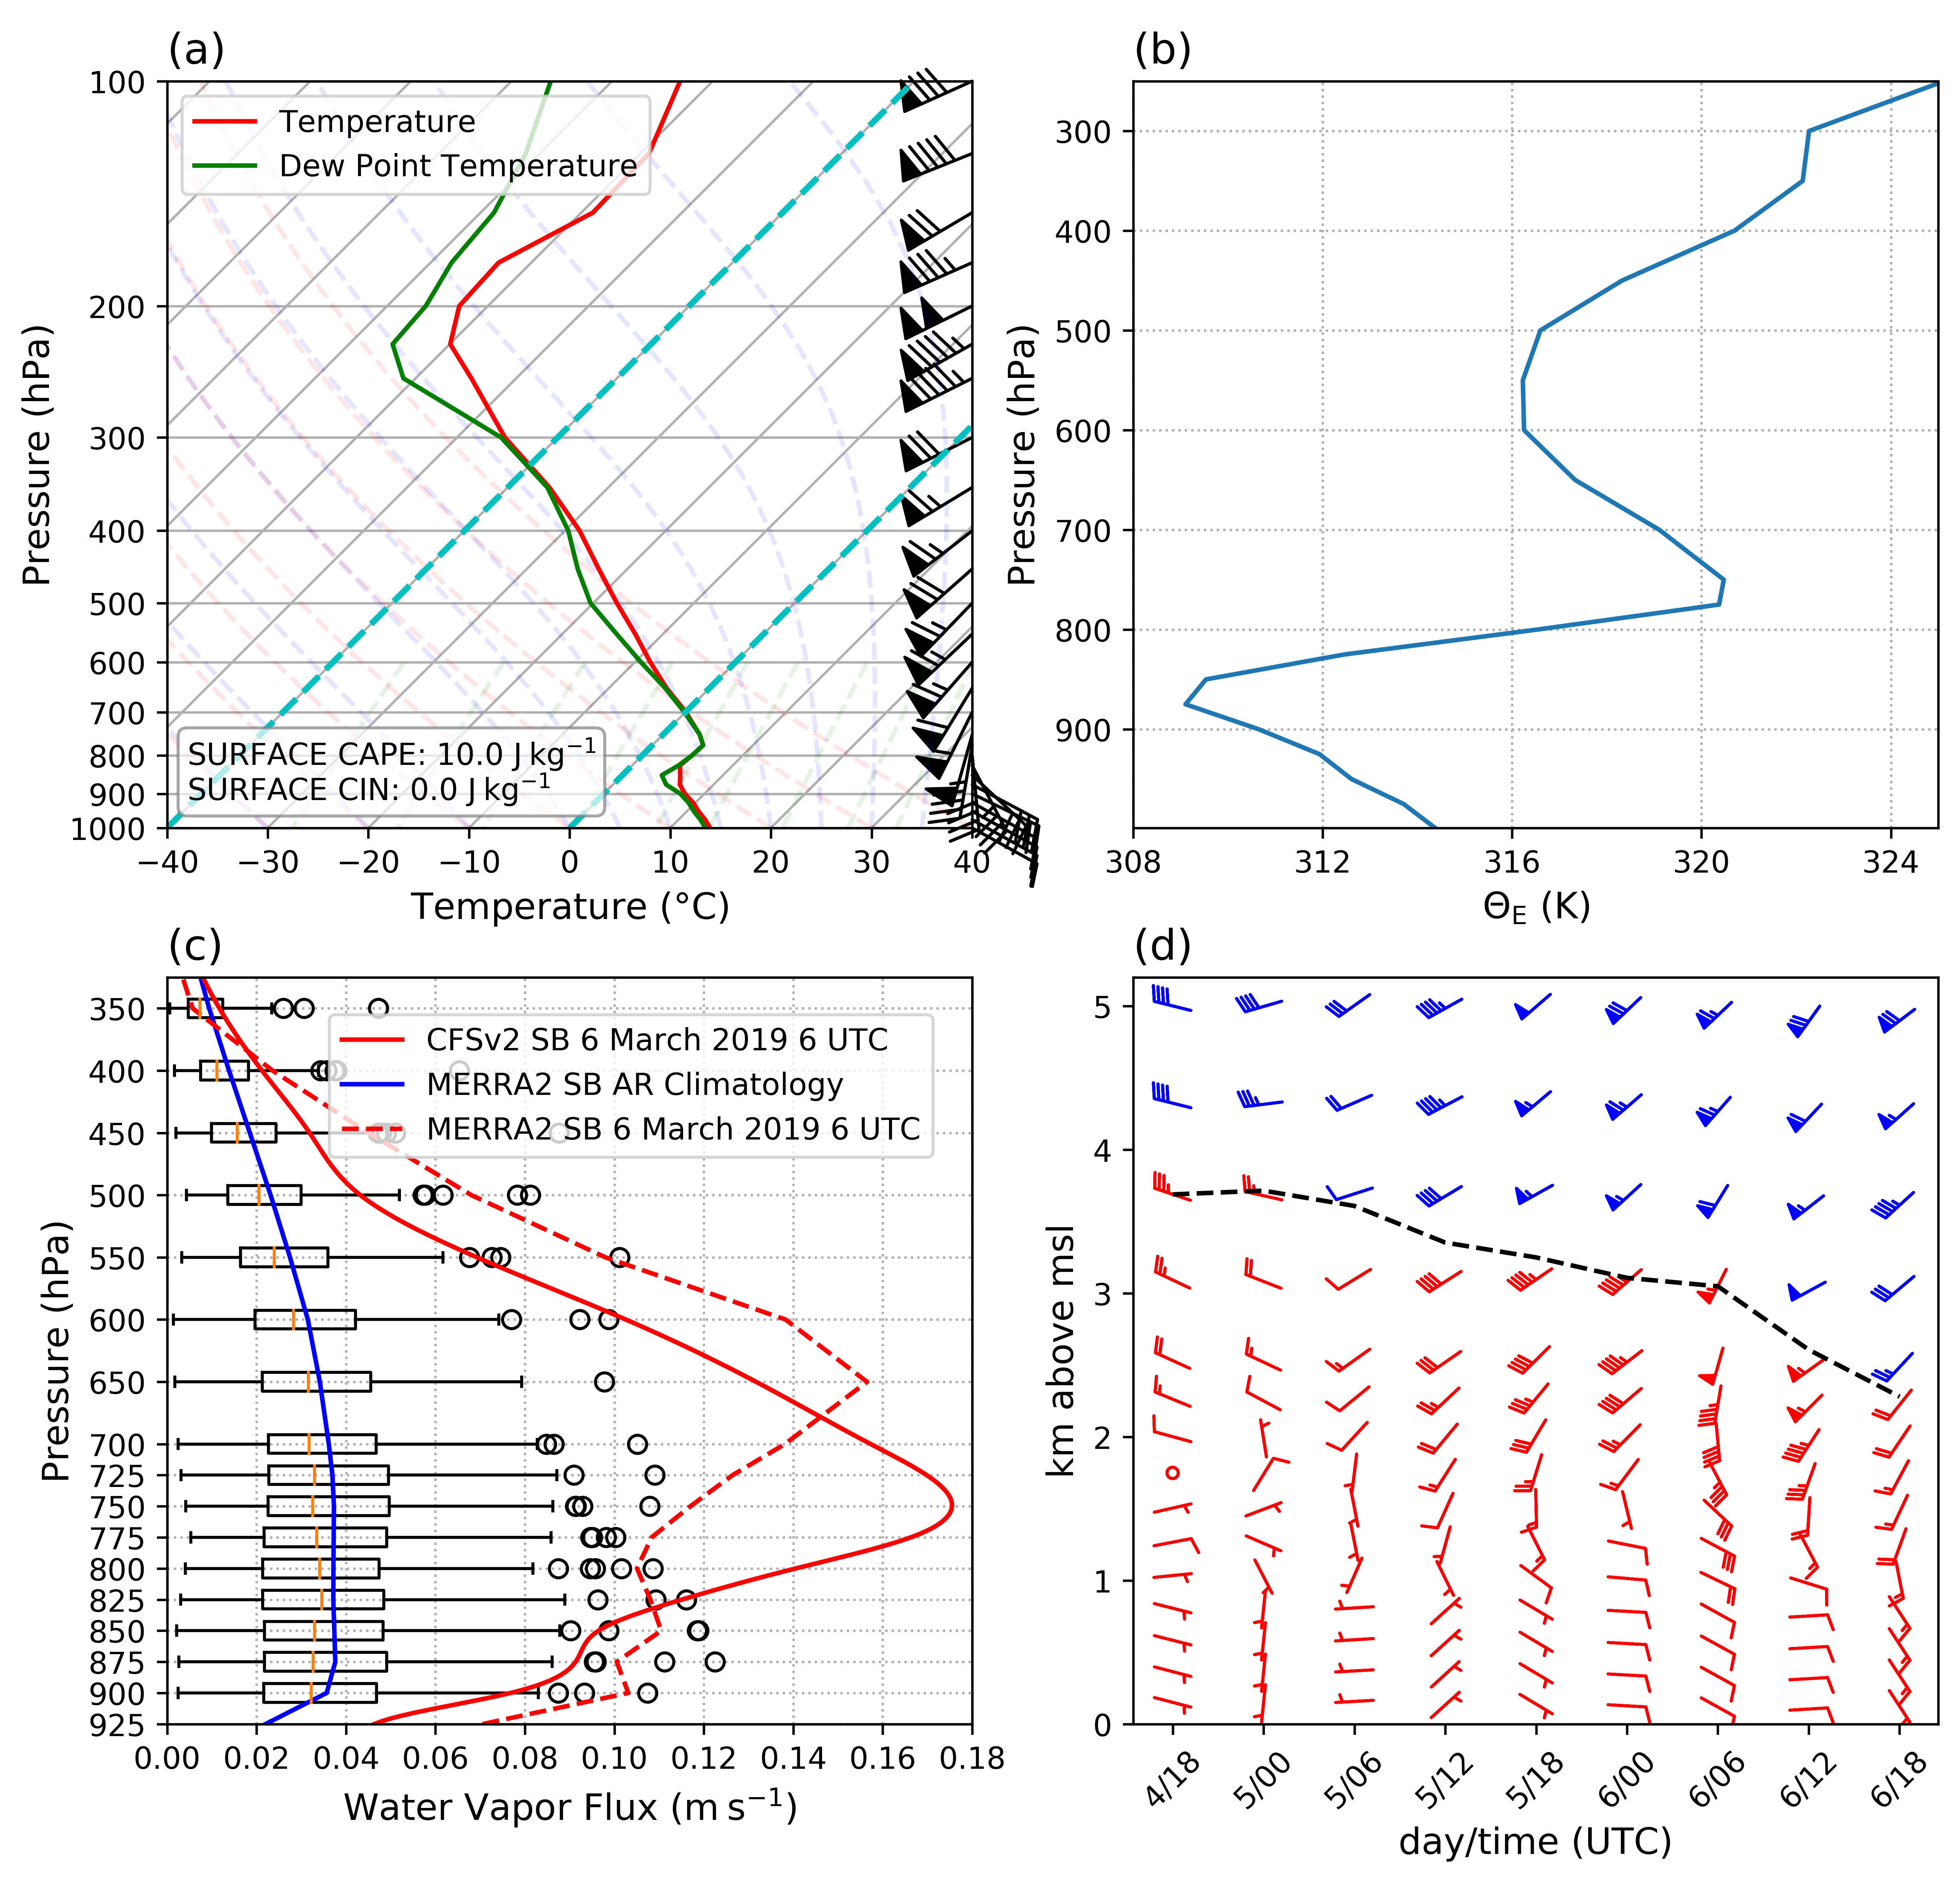

<Figure size 6300x6000 with 0 Axes>

In [12]:
## All plots together
## figsize=(width,height (inches))
fig = plt.figure(figsize=(10.5,10.0))
fig.dpi = 600
fname = './figures/f3'
fmt1 = 'png'
fmt2 = 'pdf'

numrows = 6
numcols = 6
## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = gridspec.GridSpec(numrows, numcols)

## [rows index, columns index]

######################################################
# Plot for Figure 3a - vertical sounding (skewt-lnp) #
######################################################

# ax1 = plt.subplot(gs[:, :2])
skew = SkewT(fig, rotation=45, subplot=gs[:3, :3])

skew.plot(p, t, 'r', label='Temperature')
skew.plot(p, td, 'g', label='Dew Point Temperature')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 40)

# # Calculate LCL height and plot as black dot
# lcl_pressure, lcl_temperature = mpcalc.lcl(p[0]* units.hPa, t[0]* units.degC, td[0]* units.degC)
# skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black', label='LCL')

# # Calculate full parcel profile and add to plot as black line
# prof = mpcalc.parcel_profile(p* units.hPa, t[0]* units.degC, td[0]* units.degC).to('degC')
# skew.plot(p, prof, 'k', linewidth=1, label='Parcel Profile')
# # Shade areas of CAPE and CIN
# skew.shade_cin(p, t, prof, label='CIN')
# skew.shade_cape(p, t, prof, label='CAPE')

plt.xlabel('Temperature ($\mathrm{\degree C}$)', fontsize=12)
plt.ylabel('Pressure (hPa)', fontsize=12)

# add slanted line at 0*C and -40*C
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)
skew.ax.axvline(-40, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats(alpha=0.1)
skew.plot_moist_adiabats( alpha=0.1)
skew.plot_mixing_lines(alpha=0.1)
## Add legend
plt.legend(loc='upper left')

## Add CAPE and CIN values as text
Texts = []
cape_text = 'SURFACE CAPE: '+"{:.1f}".format(da_CAPE.values.item())+' $\mathrm{J \: kg^{-1}}$'
cin_text = 'SURFACE CIN: '+"{:.1f}".format(da_CIN.values.item())+' $\mathrm{J \: kg^{-1}}$'
texts = [cape_text, cin_text]

for k in texts:
    Texts.append(TextArea(k,textprops=dict(color='k')))
texts_vbox = VPacker(children=Texts,pad=0,sep=0)
ann = AnnotationBbox(texts_vbox,(0.025, 0.075),xycoords=skew.ax.transAxes,
                            box_alignment=(0,.5),bboxprops = 
                            dict(boxstyle="round",
                                 ec=(0.5, 0.5, 0.5),
                                 fc=(1., 1., 1.),
                                 alpha=0.7))
skew.ax.add_artist(ann)

plt.title('(a)', fontsize=14, loc='left')


#############################
# Plot Fig3b -vertical EPT  #
#############################

ax1 = fig.add_subplot(gs[:3, 3:]) 

plt.plot(EPT[6], p)
plt.gca().invert_yaxis()
ax1.set_ylim(999, 250)
ax1.grid(linestyle=':')
plt.xlabel('$\mathrm{\Theta_{E}}$ (K)', fontsize=12)
plt.ylabel('Pressure (hPa)', fontsize=12)
ax1.xaxis.set_tick_params(labelsize=10)
## Add K to xticklabels
ax1.set_xticks(np.arange(308, 334, 4))
# ax3.set_xticklabels(ax3_xtick_labels)
ax1.set_xlim(308, 325)

plt.title('(b)', fontsize=14, loc='left')

######################################
# Plot Fig3c - for water vapor flux  #
######################################

ax3 = plt.subplot(gs[3:, :3])

x_levels = np.arange(0.0, 0.2, 0.02)
y_levels = np.array([900, 800, 800, 700, 600, 500, 400, 300])

ax3.boxplot(data_plot, vert=False, widths=15.0, positions=MERRA_flux.lev.values)

clim = ax3.plot(merra_mean, MERRA_flux.lev.values, 'b-', label='MERRA2 SB AR Climatology')
event = ax3.plot(power_smooth, xnew, 'r-', label='CFSv2 SB 6 March 2019 6 UTC')
merra_event = ax3.plot(wvf_merra, ds_MERRA.lev, 'r--', label='MERRA2 SB 6 March 2019 6 UTC')
plt.gca().invert_yaxis()

ax3.set_ylim([925, 325])
ax3.set_xlim([0,0.18])
ax3.set_xticks(x_levels)
# ax3.set_yticks(y_levels)
ax3.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax3.set_ylabel('Pressure (hPa)', fontsize=12)
ax3.set_xlabel('Water Vapor Flux ($\mathrm{m \: s^{-1}}$)', fontsize=12)
ax3.grid(linestyle=':')

plt.title('(c)', fontsize=14, loc='left')

## add legend
lns = event+clim+merra_event
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc='upper right', bbox_to_anchor=(0.97, 0.97))

####################################################
# Plot Fig3d - vertical wind/temperature with time #
####################################################

ax2 = plt.subplot(gs[3:, 3:])

ax2.plot(np.arange(9), zero_isotherm/1000.0, 'k--')

Q = plt.barbs(np.arange(9), y2/1000.0, u2, v2, tmp, pivot='middle',
             cmap=cmap, norm=norm, length=5)

plt.ylabel('km above msl', fontsize=12)
plt.xlabel('day/time (UTC)', fontsize=12)
xticklabels = ['4/18', '5/00', '5/06', '5/12', '5/18',
            '6/00', '6/06', '6/12', '6/18']
plt.xticks(np.arange(9), xticklabels)  # Set locations and labels
ax2.xaxis.set_tick_params(rotation=45, labelsize=10)
ax2.set_ylim([0, 5.2])
plt.title('(d)', fontsize=14, loc='left')

### Finalize Figure ### 
gs.update(hspace=1.0, wspace=1.0)
fig.savefig('%s.%s' %(fname, fmt1), bbox_inches='tight', dpi=fig.dpi)
fig.savefig('%s.%s' %(fname, fmt2), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))